In [1]:
import numpy as np
import pandas as pd
import torch

In [2]:
train_df = pd.read_csv("data/input/train.csv")
test_df = pd.read_csv("data/input/test.csv")
print(train_df.shape , test_df.shape)
print("Train Cols : " , train_df.columns)
print("Test Cols : " , test_df.columns)
print(" Label -  " , [i for i in train_df.columns if i not in test_df.columns] )

(42000, 785) (28000, 784)
Train Cols :  Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
Test Cols :  Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)
 Label -   ['label']


In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df['label'].value_counts().sort_index()

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64

In [5]:
# Convert df to numpy array
images = np.array(train_df.iloc[:,1:])

In [6]:
images.shape

(42000, 784)

In [7]:
# Scaling the image so that the values only range between 0 and 1
images = images/255.0

In [8]:
# Convert labels to one-hot encoding tensor
labels = np.array(train_df['label'])#.reshape(-1,1)
labels.shape

(42000,)

In [9]:
image_label = np.zeros((images.shape[0], 10))
image_label[np.arange(images.shape[0]), labels] = 1.0

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, image_label, test_size=0.1, stratify=train_df['label'])

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(37800, 784)
(37800, 10)
(4200, 784)
(4200, 10)


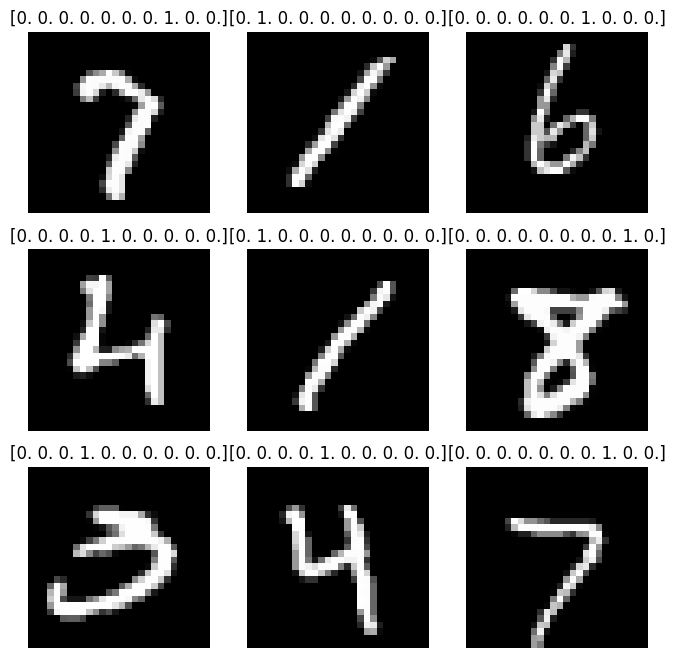

In [12]:
# Ploting some of the datapoints in the dataset
import matplotlib.pyplot as plt

# sample_img , sample_lbl = temp_train_dataset[3]
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
figure.add_subplot(rows, cols, 1)
plt.axis("off")
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(X_train), size=(1,)).item()
    sample_img = X_train[sample_idx].reshape(28, 28)
    sample_lbl = y_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(sample_lbl)
    plt.axis("off")
    plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()

In [13]:
from flax import linen as nn

# Softmax layer ignored since the loss function defined is nn.CrossEntropy()
class Brain(nn.Module):
    @nn.compact
    def __call__(self, x):  # noqa ANN001
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)

        return x


In [14]:
from turbanet import softmax_cross_entropy

def turbanet_train(dataloader, model):
    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))

    for batch, (X, y) in enumerate(dataloader):
        # Repeat for swarm_size times
        X = np.expand_dims(X.numpy(), 0).repeat(len(model), axis=0)
        y = np.expand_dims(y.numpy(), 0).repeat(len(model), axis=0)

        # Feedforward / Loss
        model, loss, prediction = model.train(X, y, softmax_cross_entropy)

        # Accuracy
        _correct = (prediction.argmax(axis=2) == y.argmax(axis=2)).astype(float).sum(axis=1)

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.mean().item()
        batch_accuracy[batch] = (_correct/dataloader.batch_size).mean().item()

        # Updating size and correct
        size += dataloader.batch_size
        correct += _correct

        if batch % 100 == 0:
            loss = loss.mean().item()
            current = batch * dataloader.batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}]")

    accuracy = (correct / size).mean().item()
    print(f"Train Accuracy: {(100*accuracy):>0.1f}%")

    return model, batch_loss, batch_accuracy


In [15]:
def turbanet_validation(dataloader, model):
    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))
    for batch, (X, y) in enumerate(dataloader):
        # Repeat for swarm_size times
        X = np.expand_dims(X.numpy(), 0).repeat(len(model), axis=0)
        y = np.expand_dims(y.numpy(), 0).repeat(len(model), axis=0)

        # Feedforward / Loss
        loss, prediction = model.evaluate(X, y, softmax_cross_entropy)

        # Accuracy
        _correct = (prediction.argmax(axis=2) == y.argmax(axis=2)).astype(float).sum(axis=1)

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.mean().item()
        batch_accuracy[batch] = (_correct/dataloader.batch_size).mean().item()

        # Updating size and correct
        size += dataloader.batch_size
        correct += _correct

    accuracy = (correct / size).mean().item()
    print(f"Validation Accuracy: {(100*accuracy):>0.1f}%")

    return batch_loss, batch_accuracy

In [16]:
# Generate batches of data
batch_size = 64

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

train_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)


In [17]:
from turbanet import TurbaTrainState, softmax_cross_entropy

swarm_size = 100
model = TurbaTrainState.swarm(Brain(), swarm_size=swarm_size, input_size=784, learning_rate=3e-3)

In [18]:
train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model, _train_batch_loss , _train_batch_accuracy = turbanet_train(train_dataloader, model)
    _valid_batch_loss , _valid_batch_accuracy = turbanet_validation(val_dataloader, model)

    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append( t + float((i+1)/len(_train_batch_loss)))

    for i in range(len(_valid_batch_loss)):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append( t + float((i+1)/len(_valid_batch_loss)))
print("Done!")

Epoch 1
-------------------------------
loss: 2.314973  [    0]
loss: 0.268479  [ 6400]
loss: 0.170634  [12800]
loss: 0.152790  [19200]
loss: 0.182633  [25600]
loss: 0.082792  [32000]
Train Accuracy: 91.9%
Validation Accuracy: 94.4%
Epoch 2
-------------------------------
loss: 0.117229  [    0]
loss: 0.120824  [ 6400]
loss: 0.066358  [12800]
loss: 0.172778  [19200]
loss: 0.100764  [25600]
loss: 0.111939  [32000]
Train Accuracy: 96.3%
Validation Accuracy: 95.3%
Epoch 3
-------------------------------
loss: 0.176528  [    0]
loss: 0.049831  [ 6400]
loss: 0.058808  [12800]
loss: 0.093475  [19200]
loss: 0.122836  [25600]
loss: 0.073737  [32000]
Train Accuracy: 97.3%
Validation Accuracy: 95.8%
Epoch 4
-------------------------------
loss: 0.016515  [    0]
loss: 0.085163  [ 6400]
loss: 0.031799  [12800]
loss: 0.083614  [19200]
loss: 0.035125  [25600]
loss: 0.077699  [32000]
Train Accuracy: 97.9%
Validation Accuracy: 96.1%
Epoch 5
-------------------------------
loss: 0.017665  [    0]
loss

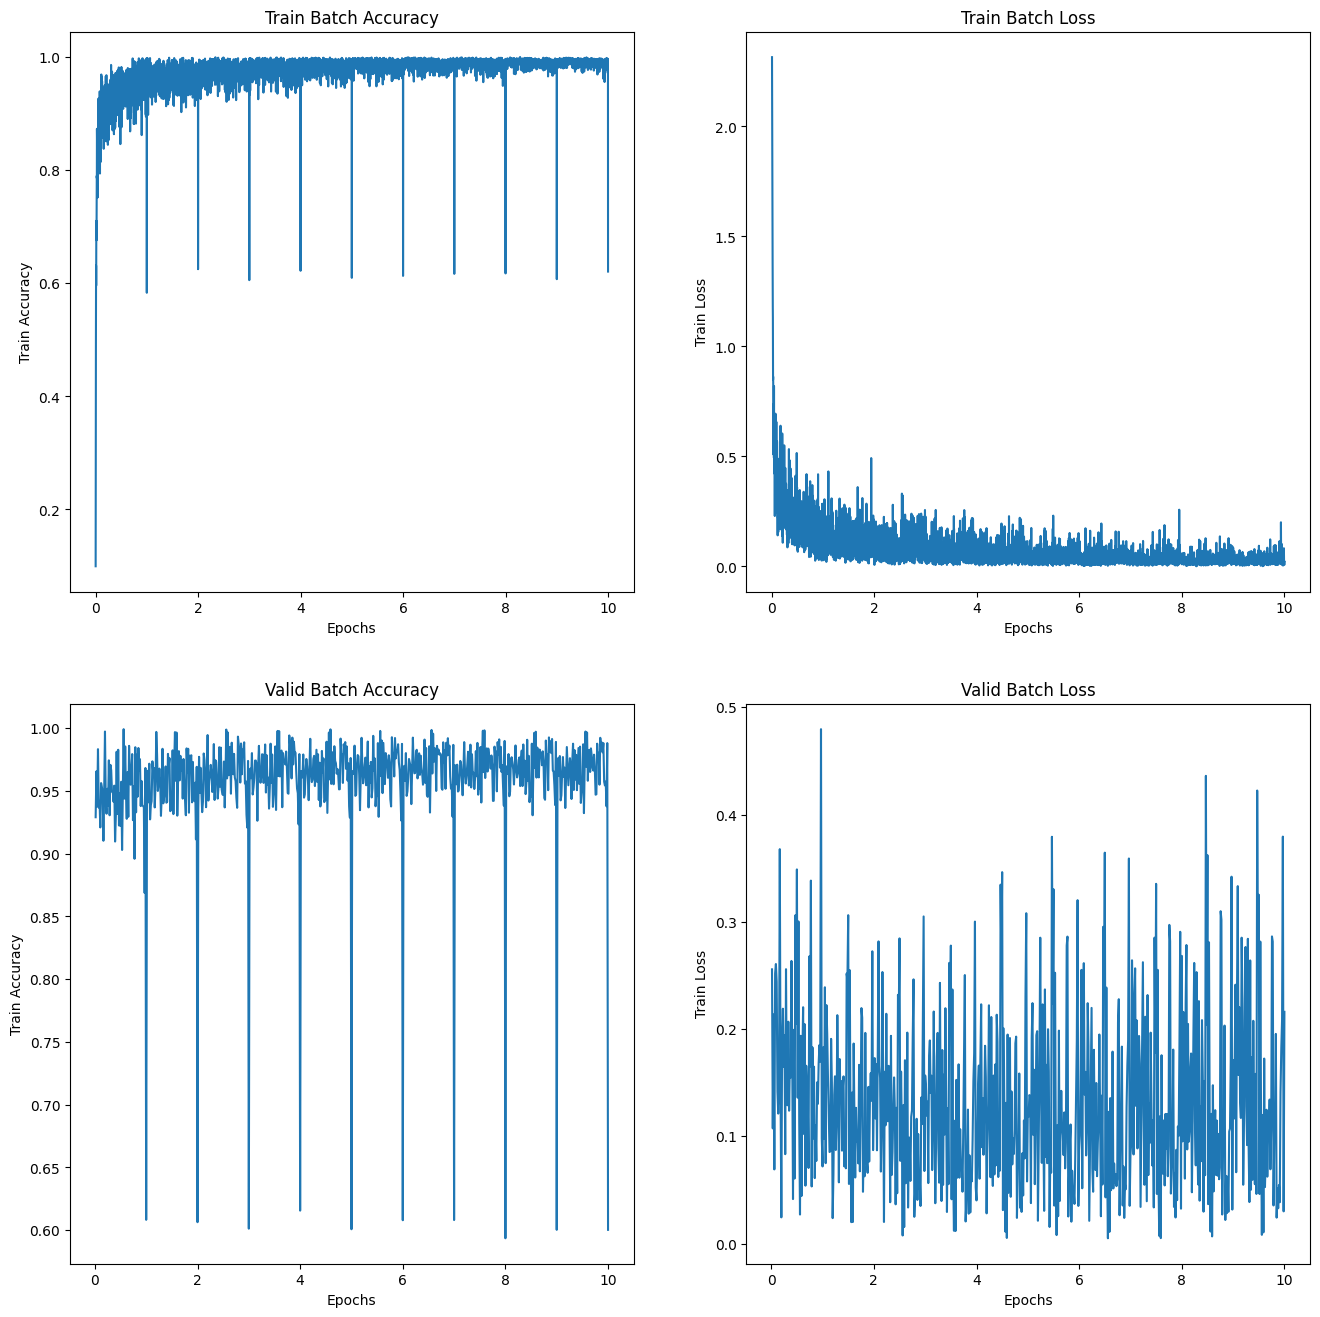

In [19]:
figure = plt.figure(figsize=(16, 16))


figure.add_subplot(2, 2, 1)
plt.plot(train_epoch_no , train_batch_accuracy)
plt.title("Train Batch Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(2, 2, 2)
plt.plot(train_epoch_no , train_batch_loss)
plt.title("Train Batch Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

figure.add_subplot(2, 2, 3)
plt.plot(valid_epoch_no , valid_batch_accuracy)
plt.title("Valid Batch Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(2, 2, 4)
plt.plot(valid_epoch_no , valid_batch_loss)
plt.title("Valid Batch Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")


plt.show()

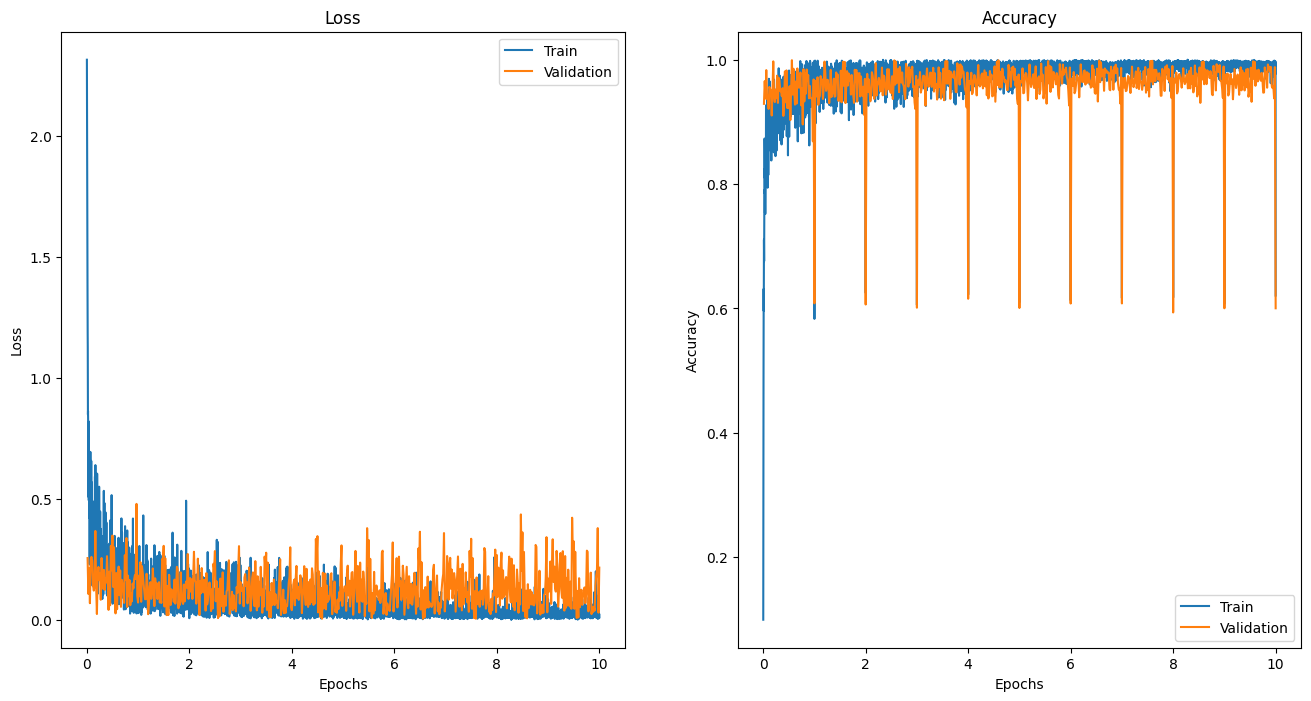

In [20]:
# Plot training and validation loss together
figure = plt.figure(figsize=(16, 8))

figure.add_subplot(1, 2, 1)
plt.plot(train_epoch_no , train_batch_loss)
plt.plot(valid_epoch_no , valid_batch_loss)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

figure.add_subplot(1, 2, 2)
plt.plot(train_epoch_no , train_batch_accuracy)
plt.plot(valid_epoch_no , valid_batch_accuracy)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

plt.show()
